In [35]:
import warnings
import sys
import os


warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.main.utilities import utils
from src.main.utilities.utils import get_dataset
from src.main.pipeline.functions import stop_words_removal, clean_text
from src.main.pipeline.pipeline import Pipeline
from src.main.pipeline.functions import stop_words_removal, clean_text, remove_contractions, unify_numbers, tfidf_vectorizer
from src.main.models.logistic import Logistic
from dataprep.eda import create_report
from wordcloud import WordCloud
from collections import Counter
from yellowbrick.text import TSNEVisualizer
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

In [37]:
#create_report(dataset)

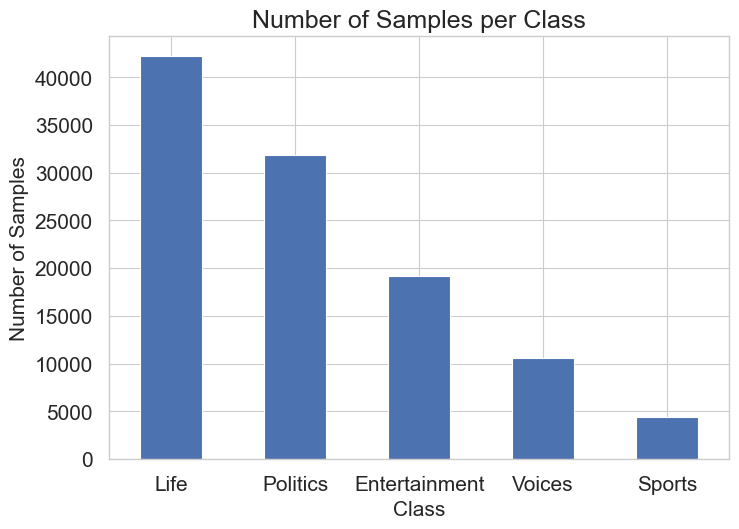

In [86]:
inputs, targets = get_dataset()
targets_series = pd.Series(targets)
class_counts = targets_series.value_counts()

class_counts.plot(kind='bar')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.title('Number of Samples per Class', fontsize=18)
plt.xticks(rotation='horizontal') 
plt.show()


In [57]:
pipeline = Pipeline([remove_contractions, clean_text, stop_words_removal, unify_numbers])
inputs, targets = get_dataset()
results = pipeline.execute(inputs)

Pipeline started
Pipeline execution time: 0:00:02.301682


0.0


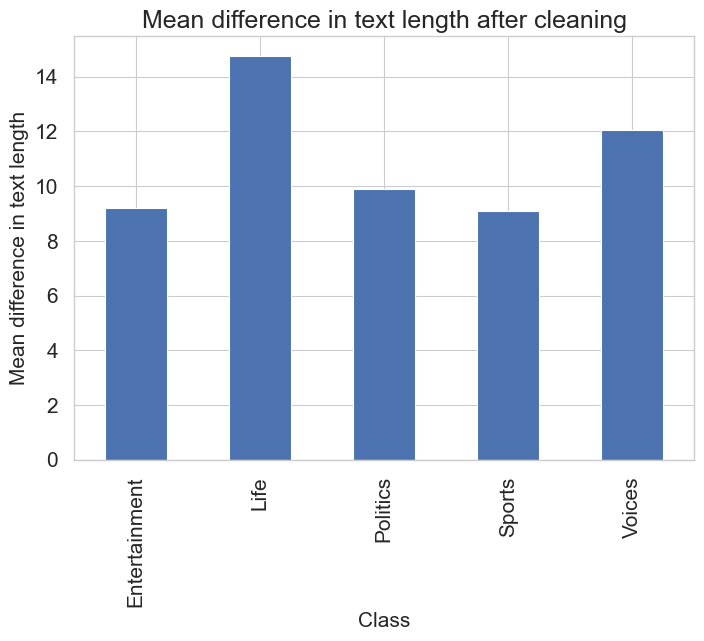

In [87]:
# Plot in mean how many caracter are removed after applying the pipeline for each class

text_lengths = [len(text.split()) for text in results.reshape(-1).tolist()]
clean_text_lengths = [len(text.split()) for text in results.flatten()]
print(np.mean(text_lengths) - np.mean(clean_text_lengths))

dataframe = pd.DataFrame({'full_article': inputs.reshape(-1).tolist(), 'class': targets})

dataframe['clean_text'] = results
dataframe['text_length'] = dataframe['full_article'].apply(lambda x: len(x.split()))
dataframe['clean_text_length'] = dataframe['clean_text'].apply(lambda x: len(x.split()))
dataframe['text_length_diff'] = dataframe['text_length'] - dataframe['clean_text_length']
dataframe['class'] = targets
dataframe.groupby('class')['text_length_diff'].mean()

dataframe.groupby('class')['text_length_diff'].mean().plot(kind='bar')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Mean difference in text length', fontsize=15)
plt.title('Mean difference in text length after cleaning', fontsize=18)
plt.show()




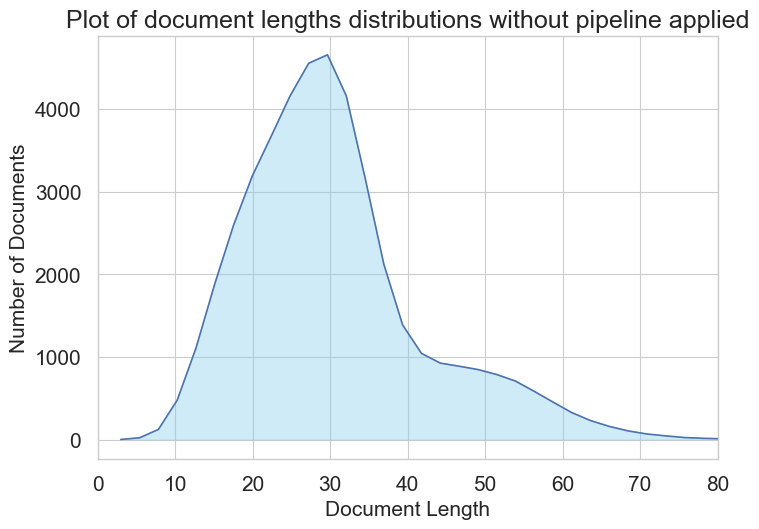

In [84]:

# Plot the number of documents with each length without pipeline
from scipy.interpolate import interp1d
document_lengths = [len(text.split()) for text in inputs.reshape(-1).tolist()]

document_lengths_count = {}
for length in document_lengths:
    if length in document_lengths_count:
        document_lengths_count[length] += 1
    else:
        document_lengths_count[length] = 1

#sns.set(font_scale=2)
# plt.rcParams.update({'font.size': 50})


sns.set_style('whitegrid')
sns.set_context('paper')
max_iter_interp = max_iter_interp[:len(max_iter_interp)]
x = list(document_lengths_count.keys())
y = list(document_lengths_count.values())

x_interp = np.linspace(min(x), max(x), 100)
y_interp = interp1d(x, y, kind='cubic')(x_interp)
y_interp = np.convolve(y_interp, np.ones(3)/3, mode='same')

plt.fill_between(x_interp, y_interp, color='skyblue', alpha=0.4)
sns.lineplot(x=x_interp, y=y_interp)
#sns.displot(document_lengths, kde=False, bins=100, fill=True)
plt.xlim(0, 80)
# matplotlib.rcParams.update({'font.size': 50})
# plt.rcParams.update({'font.size': 50})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Document Length', fontsize=15)
plt.ylabel('Number of Documents', fontsize=15)
plt.title('Plot of document lengths distributions without pipeline applied', fontsize=18)
plt.show()


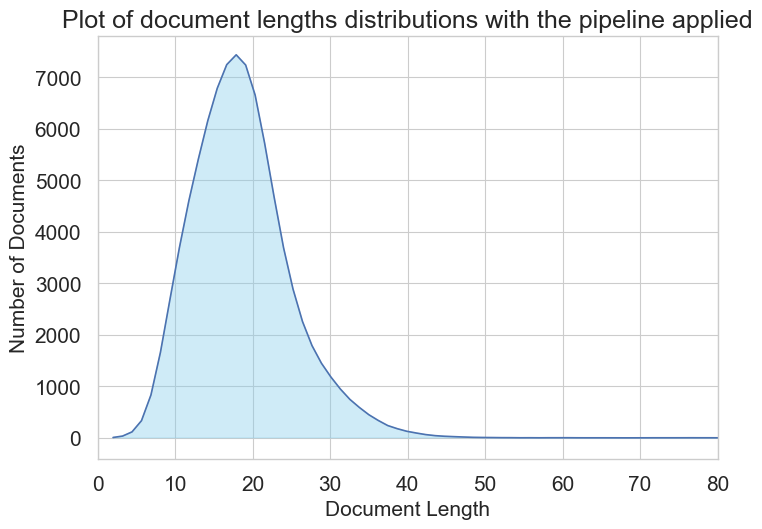

In [85]:
# Plot the number of documents with each length with pipeline

document_lengths = [len(text.split()) for text in results.reshape(-1).tolist()]

document_lengths_count = {}
for length in document_lengths:
    if length in document_lengths_count:
        document_lengths_count[length] += 1
    else:
        document_lengths_count[length] = 1

sns.set_style('whitegrid')
sns.set_context('paper')
max_iter_interp = max_iter_interp[:len(max_iter_interp)]
x = list(document_lengths_count.keys())
y = list(document_lengths_count.values())

x_interp = np.linspace(min(x), max(x), 100)
y_interp = interp1d(x, y, kind='cubic')(x_interp)
y_interp = np.convolve(y_interp, np.ones(3)/3, mode='same')

plt.fill_between(x_interp, y_interp, color='skyblue', alpha=0.4)
sns.lineplot(x=x_interp, y=y_interp)
plt.xlim(0, 80)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Document Length', fontsize=15)
plt.ylabel('Number of Documents', fontsize=15)
plt.title('Plot of document lengths distributions with the pipeline applied', fontsize=18)
plt.show()

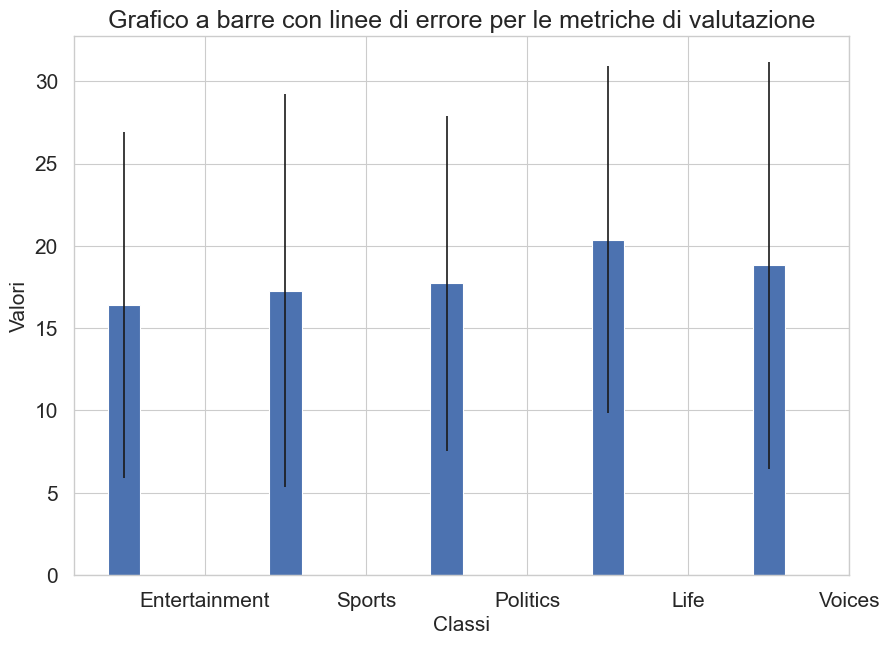

In [142]:
# Mean and variance of the document length for each class in a unique plot

# Variance of text length for every class 
dataframe['class'] = targets
dataframe['text_length'] = dataframe['full_article'].apply(lambda x: len(x.split()))
dataframe.groupby('class')['text_length'].var()

# Average Document Length per Class
dict = {}
for i in range(len(targets)):
    if targets[i] in dict:
        dict[targets[i]] += sum([len(text.split()) for text in results[i].flatten()])
    else:
        dict[targets[i]] = sum([len(text.split()) for text in results[i].flatten()])

for key in dict:
    dict[key] /= class_counts[key]



import matplotlib.cm as cm
# Nomi dei modelli
modelli = list(dict.keys())

larghezza_barre = 0.2

posizioni_barre = np.arange(len(dict))
posizioni_barre = posizioni_barre-1
medie = np.array(list(dict.values()))
std_dev = dataframe.groupby('class')['text_length'].std().values
metriche = list(dict.keys())

cmap = cm.get_cmap('viridis')  # Use the 'viridis' colormap
colors = cmap(np.linspace(0, 1, len(dict)))  # Create a list of colors

fig, ax = plt.subplots(figsize=(10, 7))  # Imposta la dimensione del grafico a 12x8 pollici
num_modelli = len(dict)
posizioni_modello = posizioni_barre+ (larghezza_barre * (0 - num_modelli / 2))
valori_modello = medie
deviazioni_standard = std_dev

ax.bar(posizioni_modello, valori_modello, width=larghezza_barre, label=modelli, yerr=deviazioni_standard, capsize=2)
#ax.set_yticks(np.arange(0.5, 1, 0.05))

#ax = sns.barplot(x=metriche, y=medie, capsize=0.1, palette='viridis', ax=ax)


# Impostazioni del grafico
ax.set_xticks(posizioni_barre)
ax.set_xticklabels(metriche, position=(0, 0))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_xlabel('Classi', fontsize=15)
ax.set_ylabel('Valori', fontsize=15)
ax.set_title('Grafico a barre con linee di errore per le metriche di valutazione', fontsize=18)
#ax.legend()
plt.xticks(rotation='horizontal')
plt.show()




In [46]:
pipeline = Pipeline([remove_contractions, clean_text, stop_words_removal]) # unify_numbers removed -> generate [NUM] tokens
inputs, targets = get_dataset()
results = pipeline.execute(inputs)

Pipeline started
Pipeline execution time: 0:00:02.183094


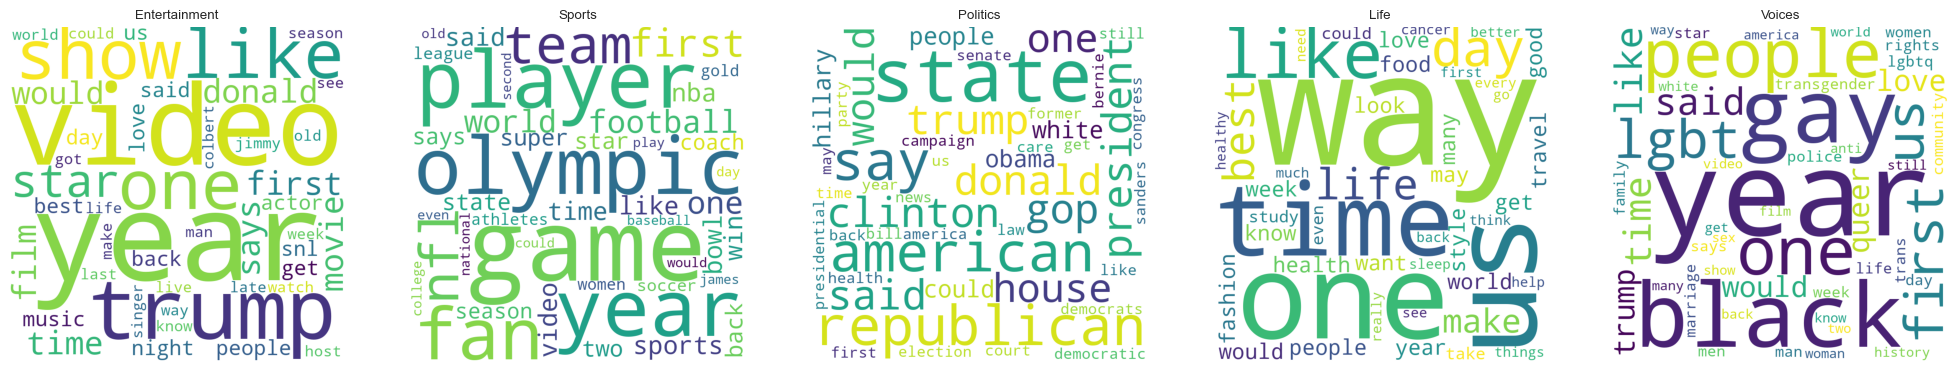

In [47]:
# Plot a word cloud for each class

custom_stopwords = ['new', 'num']

dict = {}
for i in range(len(targets)):
    if targets[i] in dict:
        dict[targets[i]] += results[i].item().split()
    else:
        dict[targets[i]] = results[i].item().split()

for key in dict:
    dict[key] = Counter(dict[key]).most_common(50)



fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, key in enumerate(dict):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = custom_stopwords, 
                min_font_size = 10).generate(' '.join([word[0] for word in dict[key]]))
    axs[i].imshow(wordcloud)
    axs[i].axis("off")
    axs[i].set_title(key)
plt.show()



In [48]:
pipeline = Pipeline([
    remove_contractions,
    clean_text,
    stop_words_removal,
    unify_numbers,
    tfidf_vectorizer
])

inputs, targets = get_dataset()

df = pd.DataFrame({'full_article': inputs.reshape(-1), 'label': targets})
df = df.groupby(targets).head(1000)
df = df[df['label'] != 'Voices']
inputs = df['full_article'].values
targets = df['label'].values
results = pipeline.execute(inputs).reshape(-1)[0]  # [0] to get the sparse matrix

Pipeline started
Pipeline execution time: 0:00:00.203327


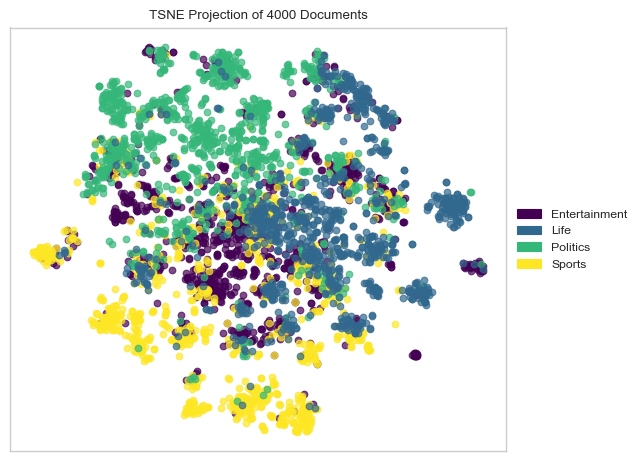

<Axes: title={'center': 'TSNE Projection of 4000 Documents'}>

In [49]:
#from matplotlib.cm import get_cmap
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis') 

tsne = TSNEVisualizer(colormap=cmap)
tsne.fit(results, targets)
tsne.show()